<a href="https://colab.research.google.com/github/So-AI-love/CtrlRegen/blob/main/ctrlregen_plus_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# download the code
!git clone https://github.com/yepengliu/CtrlRegen.git
%cd CtrlRegen

# install the required environment
! pip install -r requirements.txt

Cloning into 'CtrlRegen'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 131 (delta 49), reused 44 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (131/131), 1.16 MiB | 24.31 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/CtrlRegen
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━

In [3]:
!pip install huggingface_hub==0.25.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.1
    Uninstalling huggingface-hub-0.31.1:
      Successfully uninstalled huggingface-hub-0.31.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [7]:
!pip install mediapipe

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 980, in exec_module
  File "<frozen site>", line 642, in <module>
  File "<frozen site>", line 629, in main
  File "<frozen site>", line 410, in addsitepackages
  File "<frozen site>", line 242, in addsitedir
  File "<frozen site>", line 201, in addpackage
  File "<string>", line 1, in <module>
  File "/usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.py", line 2, in <module>
    import importlib.abc
  File "/usr/lib/python3.11/importlib/abc.py", line 19, in <module>
    from .resources.abc import ResourceReader, Traversable, TraversableResources
  File "/usr/lib/python3.11/import

In [9]:
%cd "/content/CtrlRegen"


import torch
from diffusers import ControlNetModel, UniPCMultistepScheduler, AutoencoderKL
from custom_i2i_pipeline import CustomStableDiffusionControlNetImg2ImgPipeline
from controlnet_aux import CannyDetector
from PIL import Image
import torchvision.transforms as transforms
from transformers import AutoModel, AutoImageProcessor
from utils import color_match

/content/CtrlRegen


In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

transform_size_to_512 = transforms.Compose([
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(512),
        ])

DIFFUSION_MODEL = 'SG161222/Realistic_Vision_V4.0_noVAE'
SPATIAL_CONTROL_PATH = 'spatialnet_ckp/spatial_control_ckp_14000'
SEMANTIC_CONTROL_PATH = 'semanticnet_ckp'
SEMANTIC_CONTROL_NAME = 'semantic_control_ckp_435000.bin'
IMAGE_ENCODER = 'facebook/dinov2-giant'
VAE = 'stabilityai/sd-vae-ft-mse'

spatialnet = [ControlNetModel.from_pretrained(SPATIAL_CONTROL_PATH, torch_dtype=torch.float16)]
pipe = CustomStableDiffusionControlNetImg2ImgPipeline.from_pretrained(DIFFUSION_MODEL, \
                                                         controlnet=spatialnet, \
                                                         torch_dtype=torch.float16,
                                                         safety_checker = None,
                                                         requires_safety_checker = False
                                                         )
pipe.costum_load_ip_adapter(SEMANTIC_CONTROL_PATH, subfolder='models', weight_name=SEMANTIC_CONTROL_NAME)
pipe.image_encoder = AutoModel.from_pretrained(IMAGE_ENCODER).to(device, dtype=torch.float16)
pipe.feature_extractor = AutoImageProcessor.from_pretrained(IMAGE_ENCODER)
pipe.vae = AutoencoderKL.from_pretrained(VAE).to(dtype=torch.float16)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.set_ip_adapter_scale(1.0)
pipe.set_progress_bar_config(disable=True)
pipe.to(device)

processor = CannyDetector()

def ctrl_regen_plus(input_img, step, seed=0):
    generator = torch.manual_seed(seed)
    input_img = transform_size_to_512(input_img)
    processed_img = processor(input_img, low_threshold=100, high_threshold=150)
    prompt = 'best quality, high quality'
    negative_prompt = 'monochrome, lowres, bad anatomy, worst quality, low quality'
    output_img = pipe(prompt,
                      negative_prompt=negative_prompt,
                      image = [input_img],
                      control_image = [processed_img], # spatial condition
                      ip_adapter_image = [input_img],   # semantic condition
                      strength = step,
                      generator = generator,
                      num_inference_steps=50,
                      controlnet_conditioning_scale = 1.0,
                      guidance_scale = 2.0,
                      control_guidance_start = 0,
                      control_guidance_end = 1,
                      ).images[0]
    output_img = color_match(input_img, output_img)
    return output_img

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: spatialnet_ckp/spatial_control_ckp_14000 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `token` or log in with `huggingface-cli login`.

In [13]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("yepengliu/ctrlregen")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt).images[0]

EntryNotFoundError: 404 Client Error. (Request ID: Root=1-68234f82-51ec2b7f7102c2794968c9df;30af2d46-3b0a-4711-a6a8-0f894158338a)

Entry Not Found for url: https://huggingface.co/yepengliu/ctrlregen/resolve/main/model_index.json.

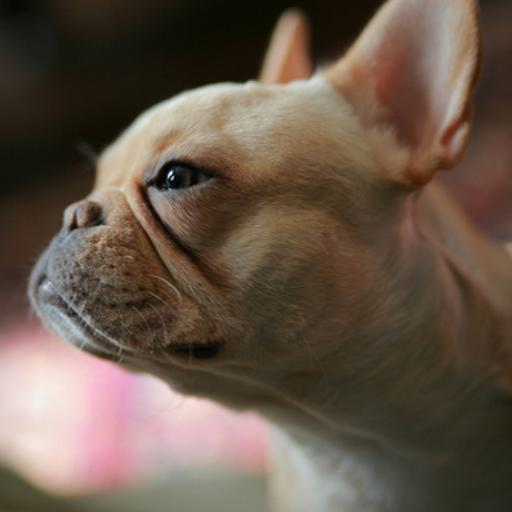

In [14]:
IMAGE_PATH = 'examples/1.jpg'
input_img = Image.open(IMAGE_PATH)
input_img

In [17]:
%cd "/content/CtrlRegen"
import ctrl_regen_plus
IMAGE_PATH = 'examples/1.jpg'
input_img = Image.open(IMAGE_PATH)
# step could be between 0 and 1; change seed to get different regeneration results
output_img = ctrl_regen_plus(input_img=input_img, step=0.5, seed=1)
output_img

/content/CtrlRegen


ModuleNotFoundError: No module named 'ctrl_regen_plus'